In [1]:
import os
os.chdir('/Users/bnowacki/Documents/Git Repositories/rapid-soh-estimation-from-short-pulses')

from rapid_soh_estimation.rapid_soh_estimation.config import *
from rapid_soh_estimation.rapid_soh_estimation.common_methods import *


# dir_preprocessed_data = Path("/Users/bnowacki/Library/CloudStorage/Dropbox/Datasets to Publish/ILCC-LFP-aging-dataset")
dir_preprocessed_data = Path("/Volumes/T7/Datasets to Publish/ILCC-LFP-aging-dataset")

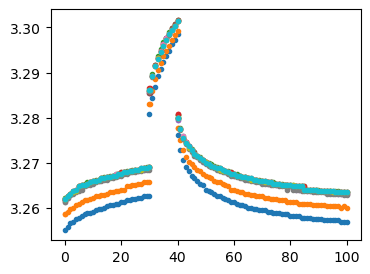

In [2]:

df = load_preprocessed_data(get_preprocessed_data_files(dir_preprocessed_data, data_type='rpt', cell_id=3))

plt.figure(figsize=(4,3))
for rpt_num in sorted(df['RPT Number'].unique())[0:10]:
	df_filt = df.loc[(df['Segment Key'] == 'slowpulse') & \
					(df['Pulse Type'] == 'chg') & \
					(df['Pulse SOC'] == 20) & \
					(df['RPT Number'] == rpt_num)]
	plt.plot(df_filt['Time (s)'].values - df_filt['Time (s)'].values[0], 
			 df_filt['Voltage (V)'], '.')
plt.show()
# print("All RPTs: ", sorted(df['RPT Number'].unique()))

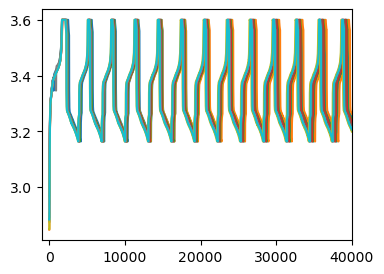

In [3]:
df = load_preprocessed_data(get_preprocessed_data_files(dir_preprocessed_data, data_type='cycling', cell_id=2))
if df is not None:
	plt.figure(figsize=(4,3))
	for week_num in sorted(df['Week Number'].unique())[0:10]:
		df_filt = df.loc[(df['Week Number'] == week_num)]
		plt.plot(df_filt['Time (s)'], df_filt['Voltage (V)'], '-')
	plt.xlim([-1000,40000])
	plt.show()

In [21]:
from rapid_soh_estimation.rapid_soh_estimation.cc_segment import *

def get_health_features_from_rpt_data(rpt_data:pd.DataFrame) -> pd.DataFrame:
	"""Extracts the health features (remaining discharge capacity and internal resistance)

	Args:
		rpt_data (pd.DataFrame): The RPT data for a given cell. Use 'load_preprocessed_data()' to get the RPT data.

	Returns:
		pd.DataFrame: A dataframe mapping each RPT to [q_dchg, dcir_chg_20, dcir_chg_50, dcir_chg_90, dcir_dchg_20, dcir_dchg_50, dcir_dchg_90].
	"""
	data_dic = {
		'rpt':[],
		'q_dchg':[],
		'dcir_chg_20':[],
		'dcir_chg_50':[],
		'dcir_chg_90':[],
		'dcir_dchg_20':[],
		'dcir_dchg_50':[],
		'dcir_dchg_90':[],
	}
	for rpt in rpt_data['RPT Number'].unique():
		data_dic['rpt'].append(rpt)
		df_filt = rpt_data.loc[rpt_data['RPT Number'] == rpt]
		# add discharge capacity for the current RPT
		data_dic['q_dchg'].append( df_filt.loc[df_filt['Segment Key'] == 'ref_dchg', 'Capacity (Ah)'].values[-1] )

		# add the six DCIR values for this RPT
		for p_type in ['chg', 'dchg']:
			for soc in [20,50,90]:
				df_pulse = df_filt.loc[(df_filt['Segment Key'] == 'slowpulse') & \
									   (df_filt['Pulse Type'] == p_type) & \
									   (df_filt['Pulse SOC'] == soc)]
				#region: interpolate pulse voltage to exactly 100 seconds 
				# each segment of pulse should be the following lengths (in seconds)
				seg_lengths = [30,10,60]
				seg_ts = []
				seg_vs = []
				for i, step in enumerate(df_pulse['Step Number'].unique()):
					df_seg = df_pulse.loc[df_pulse['Step Number'] == step]
					t = df_seg['Time (s)'].values - df_seg['Time (s)'].values[0]
					t_interp = np.arange(0, seg_lengths[i], 1)
					f_v = interpolate.PchipInterpolator(t, df_seg['Voltage (V)'].values)
					v_interp = f_v(t_interp)
					seg_ts.append(t_interp)
					seg_vs.append(v_interp)
				pulse_v = np.hstack(seg_vs)
				assert len(pulse_v) == 100
				#endregion

				# calculate dcir for this pulse type and soc
				dcir = abs(float((pulse_v[39] - pulse_v[29]) / (1.2 - 0.24)))
				# add this dcir at all three locations (three pulses per rpt)
				data_dic[f'dcir_{p_type}_{soc}'].append(dcir)

	return pd.DataFrame(data_dic)

def create_cc_modeling_data(dir_preprocessed_data:Path, segment_length:int=600, segment_overlap:float=0.5, soc_bounds=(0.3,0.9)) -> dict:
	"""Obtains all 1st-life information used for SOH estimation modeling using segments of the CC charge.

	Args:
		dir_preprocessed_data (Path): location of downloaded preprocessed data
		segment_length (int, optional): The length of each subsample of the full CC-CV charge in seconds. Defaults to 600.
        segment_overlap (float, optional): The allowable overlap of subsamples. Must be between 0 and 1 ( a value of 0.0 ensures no overlap). Defaults to 0.5.
		soc_bounds (tuple, optional): The lower and upper SOC limits (in decimal form) from which to extract the subsample of the CC-CV charge.
	Returns:
		dict: A dictionary with keys ['cell_id', 'group_id', 'rpt', 'num_cycles', 'voltage', 'q_dchg', 'dcir_chg_20', 'dcir_chg_50', 'dcir_chg_90', 'dcir_dchg_20', 'dcir_dchg_50', 'dcir_dchg_90']
	"""

	cc_data = {		
		'cell_id': [],		# the corresponding cell id of each element
		'group_id': [],		# the corresponding group id of each element
		'rpt':[],			# the corresponding rpt number of each element 
		'num_cycles':[], 	# the number of aging cycles at the current rpt number
		'voltage':[],		# each element is an array of voltage corresponding to a single subsample of the CC-CV charge
		'q_dchg':[],		# the corresponding remaining cell discharge capacity of each element
		'dcir_chg_20':[],	# the cell's internal charge resistance at 20% SOC
		'dcir_chg_50':[],	# the cell's internal charge resistance at 50% SOC
		'dcir_chg_90':[],	# the cell's internal charge resistance at 90% SOC
		'dcir_dchg_20':[],	# the cell's internal discharge resistance at 20% SOC
		'dcir_dchg_50':[],	# the cell's internal discharge resistance at 50% SOC
		'dcir_dchg_90':[],	# the cell's internal discharge resistance at 90% SOC
	}
	for cell_id in df_test_tracker['Cell ID'].unique():
		group_id = get_group_id(cell_id)
		rpt_data = load_preprocessed_data(get_preprocessed_data_files(dir_preprocessed_data, data_type='rpt', cell_id=cell_id))
		if rpt_data is None:
			raise ValueError(f"There is no preprocessed cycling data for cell {cell_id}. Please check that the preprocessed data is downloaded properly and filenames have not been altered.")
		
		# filter to only first life data
		rpt_data = rpt_data.loc[rpt_data['Life'] == '1st'].copy()
		
		# get health metrics for this cell
		df_health_features = get_health_features_from_rpt_data(rpt_data)

		# get cc-cv charge data from rpt data
		df_cc = extract_cccv_charge(rpt_data=rpt_data, plot_interpolation=False)
		
		#region: get information from each RPT (just the CC-CV charge data)
		for rpt_num,df_split in df_cc.sort_values(by=['RPT Number', 'Time (s)'], ascending=[True, True]).groupby('RPT Number'):
			#region: get q_dchg and cycle numbers for this rpt
			q_dchg = df_health_features.loc[df_health_features['rpt'] == rpt_num, 'q_dchg'].values[0]
			num_cycles = rpt_data.loc[rpt_data['RPT Number'] == rpt_num, 'Num Cycles'].max()
			#endregion

			#region: drop data that falls outside specified SOC bounds
			for b in soc_bounds: assert b >= 0.0 and b <= 1.0
			# lower voltage limit per soc_bounds[1] (inclusive)
			vlim_lower = df_v_vs_soc_1c_chg.loc[df_v_vs_soc_1c_chg['soc'] <= soc_bounds[0]*100, 'v'].values[-1]
			# upper voltage limit per soc_bounds[1] (exclusive)
			vlim_upper = df_v_vs_soc_1c_chg.loc[df_v_vs_soc_1c_chg['soc'] < soc_bounds[1]*100, 'v'].values[-1]
			# filter df to only within this voltage range
			df_split = df_split.loc[(df_split['Voltage (V)'] >= vlim_lower) & (df_split['Voltage (V)'] < vlim_upper)]
			#endregion

			# get CC subsamples from this full CC-CV charge signal
			v_samples = get_cc_subsamples(df_split['Voltage (V)'].values, segment_length=segment_length, segment_overlap=segment_overlap)
			
			# add other identifying info corresponding to this CC subsample
			for v in v_samples:
				if not len(v) == segment_length: continue
				cc_data['cell_id'].append(cell_id)
				cc_data['group_id'].append(group_id)
				cc_data['rpt'].append(rpt_num)
				cc_data['num_cycles'].append(num_cycles)
				cc_data['voltage'].append(v)
				cc_data['q_dchg'].append(q_dchg)
				cc_data['dcir_chg_20'].append(
					df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_chg_20'].values[0])
				cc_data['dcir_chg_50'].append(
					df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_chg_50'].values[0])
				cc_data['dcir_chg_90'].append(
					df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_chg_90'].values[0])
				cc_data['dcir_dchg_20'].append(
					df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_dchg_20'].values[0])
				cc_data['dcir_dchg_50'].append(
					df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_dchg_50'].values[0])
				cc_data['dcir_dchg_90'].append(
					df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_dchg_90'].values[0])
		#endregion


	#region: convert all dic values to np arrays
	cc_data['cell_id'] = np.asarray(cc_data['cell_id'])
	cc_data['group_id'] = np.asarray(cc_data['group_id'])
	cc_data['rpt'] = np.asarray(cc_data['rpt'])
	cc_data['num_cycles'] = np.asarray(cc_data['num_cycles'])
	cc_data['voltage'] = np.asarray(cc_data['voltage'])
	cc_data['q_dchg'] = np.asarray(cc_data['q_dchg'])
	cc_data['dcir_chg_20'] = np.asarray(cc_data['dcir_chg_20'])
	cc_data['dcir_chg_50'] = np.asarray(cc_data['dcir_chg_50'])
	cc_data['dcir_chg_90'] = np.asarray(cc_data['dcir_chg_90'])
	cc_data['dcir_dchg_20'] = np.asarray(cc_data['dcir_dchg_20'])
	cc_data['dcir_dchg_50'] = np.asarray(cc_data['dcir_dchg_50'])
	cc_data['dcir_dchg_90'] = np.asarray(cc_data['dcir_dchg_90'])
	#endregion
	return cc_data

def create_slowpulse_modeling_data(dir_preprocessed_data:Path) -> dict:
	"""Obtains all 1st-life information used for SOH estimation modeling using slow pulses.

	Args:
		dir_preprocessed_data (Path): location of downloaded preprocessed data
	Returns:
		dict: A dictionary with keys ['cell_id', 'group_id', 'rpt', 'soc', 'pulse_type', 'voltage', 'q_dchg', 'dcir_chg_20', 'dcir_chg_50', 'dcir_chg_90', 'dcir_dchg_20', 'dcir_dchg_50', 'dcir_dchg_90']
	"""

	pulse_data = {		
		'cell_id': [],		# the corresponding cell id of each element
		'group_id': [],		# the corresponding group id of each element
		'rpt':[],			# the corresponding rpt number of each element 
		'num_cycles':[],	# the number of aging cycles at the current rpt number
		'soc':[], 			# the corresponding SOC of each pulse {20,50,90}
		'soc - coulomb':[],
		'pulse_type':[],	# the corresponding pulse type {'chg', 'dchg'}
		'voltage':[],		# each element is an array of voltage corresponding to a single slow pulse
		'q_dchg':[],		# the corresponding remaining cell discharge capacity of each element
		'dcir_chg_20':[],	# the cell's internal charge resistance at 20% SOC
		'dcir_chg_50':[],	# the cell's internal charge resistance at 50% SOC
		'dcir_chg_90':[],	# the cell's internal charge resistance at 90% SOC
		'dcir_dchg_20':[],	# the cell's internal discharge resistance at 20% SOC
		'dcir_dchg_50':[],	# the cell's internal discharge resistance at 50% SOC
		'dcir_dchg_90':[],	# the cell's internal discharge resistance at 90% SOC
	}
	
	for cell_id in df_test_tracker['Cell ID'].unique():
		group_id = get_group_id(cell_id)
		rpt_data = load_preprocessed_data(get_preprocessed_data_files(dir_preprocessed_data, data_type='rpt', cell_id=cell_id))
		if rpt_data is None:
			raise ValueError(f"There is no preprocessed cycling data for cell {cell_id}. Please check that the preprocessed data is downloaded properly and filenames have not been altered.")
	
		# filter to only first life data
		rpt_data = rpt_data.loc[rpt_data['Life'] == '1st'].copy()

		# get health metrics for this cell
		df_health_features = get_health_features_from_rpt_data(rpt_data)
		
		#region: add cumulative capacity column (for coulomb counting)
		q_cums = np.zeros(len(rpt_data))
		for rpt_num in rpt_data['RPT Number'].unique():
			df_rpt = rpt_data.loc[rpt_data['RPT Number'] == rpt_num]
			dqs = np.zeros(len(df_rpt))
			for step_num in df_rpt['Step Number'].unique():
				df_step = df_rpt.loc[(df_rpt['Step Number'] == step_num)]
				idxs = df_step.index.values - df_rpt.index.values[0]
				
				assert len(df_step['State'].unique()) == 1
				sign = -1 if 'DChg' in df_step['State'].unique()[0] else 1

				dqs[idxs[1:]] = df_step['Capacity (Ah)'].diff().values[1:] * sign
				dqs[idxs[0]] = 0

			# # need to offset q_cum to start at first charge step after discharge 
			# offset_idx = df_rpt.loc[df_rpt['Step Number'] == 2].index.values[0] - df_rpt.index.values[0]
			q_cum = np.cumsum(dqs)
			q_cums[df_rpt.index.values] = q_cum - q_cum[-1] # q_cum[offset_idx]

		rpt_data['Cumulative Capacity (Ahr)'] = q_cums
		#endregion

		# get information from each RPT 
		for rpt_num,df_split in rpt_data.sort_values(by=['RPT Number', 'Time (s)'], ascending=[True, True]).groupby('RPT Number'):
			#region: get q_dchg and cycle numbers for this rpt
			q_dchg = df_health_features.loc[df_health_features['rpt'] == rpt_num, 'q_dchg'].values[0]
			num_cycles = df_split['Num Cycles'].max()
			#endregion

			# get pulse data for each pulse type and soc combination
			for soc in [20, 50, 90]:
				for p_type in ['chg', 'dchg']:
					# filter dataframe to current slow pulse (using RPT number, SOC, pulse type)
					df_pulse = df_split.loc[(df_split['Segment Key'] == 'slowpulse') & \
											(df_split['Pulse SOC'] == soc) & \
											(df_split['Pulse Type'] == p_type)]

					#region: interpolate pulse voltage to exactly 100 seconds 
					# each segment of pulse should be the following lengths (in seconds)
					seg_lengths = [30,10,60]
					seg_ts = []
					seg_vs = []
					for i, step in enumerate(df_pulse['Step Number'].unique()):
						df_seg = df_pulse.loc[df_pulse['Step Number'] == step]
						t = df_seg['Time (s)'].values - df_seg['Time (s)'].values[0]
						t_interp = np.arange(0, seg_lengths[i], 1)
						f_v = interpolate.PchipInterpolator(t, df_seg['Voltage (V)'].values)
						v_interp = f_v(t_interp)
						seg_ts.append(t_interp)
						seg_vs.append(v_interp)
		
					pulse_v = np.hstack(seg_vs)
					assert len(pulse_v) == 100
					#endregion

					# add values to dictionary
					pulse_data['cell_id'].append(cell_id)
					pulse_data['group_id'].append(group_id)
					pulse_data['rpt'].append(rpt_num)
					pulse_data['num_cycles'].append(num_cycles)
					pulse_data['soc'].append(soc)
					pulse_data['soc - coulomb'].append( df_pulse['Cumulative Capacity (Ahr)'].values[0] / q_dchg * 100 )
					pulse_data['pulse_type'].append(p_type)
					pulse_data['voltage'].append(pulse_v)
					pulse_data['q_dchg'].append(q_dchg)

					pulse_data['dcir_chg_20'].append(
						df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_chg_20'].values[0])
					pulse_data['dcir_chg_50'].append(
						df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_chg_50'].values[0])
					pulse_data['dcir_chg_90'].append(
						df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_chg_90'].values[0])
					pulse_data['dcir_dchg_20'].append(
						df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_dchg_20'].values[0])
					pulse_data['dcir_dchg_50'].append(
						df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_dchg_50'].values[0])
					pulse_data['dcir_dchg_90'].append(
						df_health_features.loc[df_health_features['rpt'] == rpt_num, 'dcir_dchg_90'].values[0])

	#region: convert all dic values to np arrays
	pulse_data['cell_id'] = np.asarray(pulse_data['cell_id'])
	pulse_data['group_id'] = np.asarray(pulse_data['group_id'])
	pulse_data['rpt'] = np.asarray(pulse_data['rpt'])
	pulse_data['num_cycles'] = np.asarray(pulse_data['num_cycles'])
	pulse_data['soc'] = np.asarray(pulse_data['soc'])
	pulse_data['soc - coulomb'] = np.asarray(pulse_data['soc - coulomb'])
	pulse_data['pulse_type'] = np.asarray(pulse_data['pulse_type'])
	pulse_data['voltage'] = np.asarray(pulse_data['voltage'])
	pulse_data['q_dchg'] = np.asarray(pulse_data['q_dchg'])
	pulse_data['dcir_chg_20'] = np.asarray(pulse_data['dcir_chg_20'])
	pulse_data['dcir_chg_50'] = np.asarray(pulse_data['dcir_chg_50'])
	pulse_data['dcir_chg_90'] = np.asarray(pulse_data['dcir_chg_90'])
	pulse_data['dcir_dchg_20'] = np.asarray(pulse_data['dcir_dchg_20'])
	pulse_data['dcir_dchg_50'] = np.asarray(pulse_data['dcir_dchg_50'])
	pulse_data['dcir_dchg_90'] = np.asarray(pulse_data['dcir_dchg_90'])
	#endregion

	return pulse_data

def save_modeling_data(data_type:str, data:dict, filename:str=None) -> Path:
	"""Saves generated modeling data using a pre-set organizational method

	Args:
		data_type (str): {'cc', 'slowpulse', 'fastpulse', 'ultrafastpulse'}. The data_type the data corresponds to.
		data (dict): The data to be saved. Should be in the standard dictionary format
		filename (str, optional): Can optionally specify the filename. If not provided, an auto-indexing naming convention is used. Defaults to None.
	
	Returns:
		Path: the Path object to where the data was saved
	"""

	assert data_type in ['cc', 'slowpulse', 'fastpulse', 'ultrafastpulse']

	# may need to make the directory if first time being run
	if not dir_processed_data.joinpath(data_type).exists():
		dir_processed_data.joinpath(data_type).mkdir(exist_ok=True, parents=True)

	#region: use auto-naming convention if filename wasn't specified
	file_idx = None
	if filename is None:
		prev_files = sorted(dir_processed_data.joinpath(data_type).glob(f"modeling_data_{data_type}*"))
		if len(prev_files) == 0: 
			file_idx = 0
		else:
			split_start_idx = str(prev_files[-1]).rindex(f'{data_type}_') + len(f'{data_type}_')
			split_stop_idx = str(prev_files[-1]).rindex('.pkl')
			file_idx = int(str(prev_files[-1])[split_start_idx:split_stop_idx]) + 1
		filename = f"modeling_data_{data_type}_{file_idx}.pkl"
	#endregion

	# save data and return path to where data was saved
	f = dir_processed_data.joinpath(data_type, filename)
	pickle.dump(data, open(f, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
	return f

def load_modeling_data(data_type:str, filepath:str=None) -> dict:
	"""Loads saved modeling data for the specified data type

	Args:
		data_type (str): {'cc', 'slowpulse', 'fastpulse', 'ultrafastpulse'}. The data_type the data corresponds to.
		filepath (str, optional): Can optionally specify the file path of the saved data. If not provided, the most recent auto-named file will be returned.

	Returns:
		dict: The saved data
	"""
	assert data_type in ['cc', 'slowpulse', 'fastpulse', 'ultrafastpulse']

	if filepath is not None:
		f = dir_processed_data.joinpath(data_type, filepath)
		if not f.exists(): 
			raise ValueError(f"Could not find specified file: {f}")
		return pickle.load(open(f, 'rb'))
	else:
		prev_files = sorted(dir_processed_data.joinpath(data_type).glob(f"modeling_data_{data_type}_*"))
		if len(prev_files) == 0: 
			raise ValueError("Could not find any previously saved files. Try providing a filename")
		else:
			return pickle.load(open(prev_files[-1], 'rb'))


# cc_data = create_cc_modeling_data(dir_preprocessed_data=dir_preprocessed_data, 
# 								  segment_length=600, segment_overlap=0.5, soc_bounds=(0.3,0.9))
# save_modeling_data(data_type='cc', data=cc_data)
# pulse_data = create_slowpulse_modeling_data(dir_preprocessed_data)
# save_modeling_data(data_type='slowpulse', data=pulse_data)

cc_data = load_modeling_data(data_type='cc')
pulse_data = load_modeling_data(data_type='slowpulse')

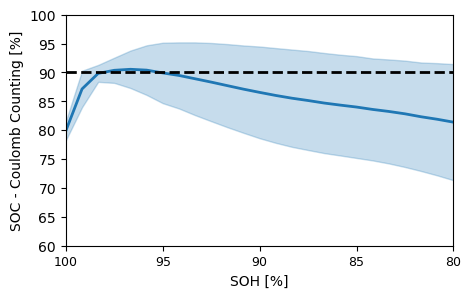

In [145]:
# x

colors = {
	'default':['C0', 'C1', 'C2'],
	'by_group':{
		1:{'main':'#4E79A7', 'fill':'#A0CBE8'},
		2:{'main':'#F28E2B', 'fill':'#FFBE7D'},
		3:{'main':'#59A14F', 'fill':'#8CD17D'},
		4:{'main':'#D37295', 'fill':'#FABFD2'},
		5:{'main':'#499894', 'fill':'#86BCB6'},
		6:{'main':'#E15759', 'fill':'#FF9D9A'},
		7:{'main':'#363433', 'fill':'#94908e'},
		8:{'main':'#B6992D', 'fill':'#F1CE63'},
		9:{'main':'#B07AA1', 'fill':'#D4A6C8'},
		10:{'main':'#9D7660', 'fill':'#D7B5A6'},
		11:{'main':'#637939', 'fill':'#8CA252'},
	},
}

def plot_soc_drift(socs_to_plot=[20,50,90], color_by_group=True, filename:Path=None):
	#region: get plotting data
	plotting_res = pd.DataFrame(columns=['cell_id', 'group_id', 'soc', 'soc_coulomb', 'soh'])
	soh_interp = np.linspace(80,100,25)
	temp = {'cell_id':[],'group_id':[],'soc_coulomb':[],'soc':[],'soh':[]}
	for i, soc in enumerate([20,50,90]):
		for cell_id in sorted(np.unique(pulse_data['cell_id']), reverse=False):
			filts_idxs = np.where( (pulse_data['cell_id'] == cell_id) &  \
								(pulse_data['soc'] == soc) & \
								(pulse_data['pulse_type'] == 'chg'))
			q0 = pulse_data['q_dchg'][filts_idxs][np.where(pulse_data['rpt'][filts_idxs] == 0)]
			sohs = pulse_data['q_dchg'][filts_idxs] / q0 * 100
			socs_coulomb = pulse_data['soc - coulomb'][filts_idxs]

			
			sort_idxs = np.argsort(sohs)
			f_soc = interpolate.PchipInterpolator(sohs[sort_idxs], socs_coulomb[sort_idxs])
			socs_coulomb_interp = f_soc(soh_interp)

			temp['cell_id'] = np.full(len(soh_interp), cell_id)
			temp['group_id'] = np.full(len(soh_interp), get_group_id(cell_id))
			temp['soc'] = np.full(len(soh_interp), soc)
			temp['soc_coulomb'] = socs_coulomb_interp
			temp['soh'] = soh_interp

			if plotting_res.empty:
				plotting_res = pd.DataFrame(temp)
			else:
				plotting_res = pd.concat([plotting_res, pd.DataFrame(temp)], ignore_index=True)
	#endregion

	fig, ax = plt.subplots(figsize=(5,3))
	plotting_res = plotting_res.loc[plotting_res['cell_id'] != 42]

	if color_by_group:
		for group_id,df_split in plotting_res.sort_values(by=['group_id', 'cell_id', 'soc', 'soh'], ascending=[True, True, True, True]).groupby('group_id'):
			# for each group, group by cell_id
			means = df_split.groupby(['soc', 'soh'])['soc_coulomb'].mean().reset_index()
			stds = df_split.groupby(['soc', 'soh'])['soc_coulomb'].std().reset_index()

			for i, soc in enumerate(socs_to_plot):
				if i == 0:
					ax.plot(
						means.loc[means['soc'] == soc, 'soh'], 
						means.loc[means['soc'] == soc, 'soc_coulomb'],
						'-', linewidth=2, color=colors['by_group'][group_id]['main'], label=group_id, zorder=2)
				else:
					ax.plot(
						means.loc[means['soc'] == soc, 'soh'], 
						means.loc[means['soc'] == soc, 'soc_coulomb'],
						'-', linewidth=2, color=colors['by_group'][group_id]['main'], zorder=2)
				ax.fill_between(
					means.loc[means['soc'] == soc, 'soh'], 
					means.loc[means['soc'] == soc, 'soc_coulomb'] + 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					means.loc[means['soc'] == soc, 'soc_coulomb'] - 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					color=colors['by_group'][group_id]['fill'], alpha=0.25, zorder=1)
	else:
		means = plotting_res.groupby(['soc', 'soh'])['soc_coulomb'].mean().reset_index()
		stds = plotting_res.groupby(['soc', 'soh'])['soc_coulomb'].std().reset_index()

		for i, soc in enumerate(socs_to_plot):
			ax.plot(
				means.loc[means['soc'] == soc, 'soh'], 
				means.loc[means['soc'] == soc, 'soc_coulomb'],
				'-', linewidth=2, color=colors['default'][0], zorder=2)
			ax.fill_between(
					means.loc[means['soc'] == soc, 'soh'], 
					means.loc[means['soc'] == soc, 'soc_coulomb'] + 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					means.loc[means['soc'] == soc, 'soc_coulomb'] - 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					color=colors['default'][0], alpha=0.25, zorder=1)

	soh_range = np.arange(100,79,-5)
	soc_bounds_mapping = {20:[15,25], 50:[30,60], 90:[60,100]}
	soc_bounds = (soc_bounds_mapping[min(socs_to_plot)][0], soc_bounds_mapping[max(socs_to_plot)][1])

	for soc in socs_to_plot:
		ax.plot(soh_range, np.full(len(soh_range), soc), 'k--', linewidth=2)

	ax.set_xlim([np.max(soh_range), np.min(soh_range)])
	ax.set_xticks(soh_range, labels=soh_range, fontsize=9)
	ax.set_ylim(soc_bounds)
	# ax.set_yticks(np.arange(20,101,20), labels=np.arange(20,101,20), fontsize=9)
	ax.set_xlabel("SOH [%]", fontsize=10)
	ax.set_ylabel("SOC - Coulomb Counting [%]", fontsize=10)
	if color_by_group:
		ax.legend(
			title='Group ID', ncol=1, title_fontsize=10, fontsize=8,
			loc='center right', bbox_to_anchor=(1.3, 0.5), 
			handlelength=1, borderpad=0.75,
			fancybox=True, shadow=True)
		box = ax.get_position()
		ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
	# fig.tight_layout(pad=0.5)
	if filename is not None:
		fig.savefig(filename, dpi=300, bbox_inches="tight")
	plt.show()

socs_to_plot = [90]
color_by_group = False
dir_drift = Path("/Users/bnowacki/Desktop/Paper Revision Figures/SOC Drift Analysis")
filename = dir_drift.joinpath(f"SOC_Drift_{socs_to_plot}{'_byGroup' if color_by_group else ''}.pdf")
plot_soc_drift(socs_to_plot, color_by_group, filename=None)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import keras
from copy import copy, deepcopy


def get_cell_ids_in_group(group_id:int) -> np.ndarray:
	"""Gets all cell ids in the specified group id

	Args:
		group_id (int): The id of the group for which to return the cell ids 

	Returns:
		np.ndarray: An array of all cell_ids in the specified group
	"""
	assert group_id in df_test_tracker['Group'].unique(), f"Invalid group id entered: {group_id}. The group id must be one of the following: {df_test_tracker['Group'].unique()}"
	start = (group_id - 1) * 6
	end = min(start+6, 64)
	return np.arange(start, end, 1) + 2

class Custom_CVSplitter():
	"""A custom cross-validation split wrapper. Allows for splitting by group_id or cell_id and returns n_splits number of cross validation folds
	"""

	def __init__(self, n_splits=3, split_type='group_id', rand_seed=None):
		assert isinstance(n_splits, int), "\'n_splits\' must be an interger value"
		self.n_splits = n_splits
		self.allowed_split_types = ['group_id', 'cell_id']
		assert split_type in self.allowed_split_types, "ValueError. \'split type\' must be one of the following: {}".format(self.allowed_split_types)
		self.split_type = split_type
		self.rand_seed = rand_seed
		
	def get_n_splits(self, X, y, groups):
		return self.n_splits

	def split(self, X, y, cell_ids):
		'given input data (X) and output data (y), returns (train_idxs, test_idxs) --> idxs are relative to X & y'
		kf = None
		if self.rand_seed is None:
			kf = KFold(n_splits=self.n_splits, shuffle=True)
		else:
			kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.rand_seed)
		
		if self.split_type == self.allowed_split_types[0]:      # 'group_id'
			group_ids = np.arange(1, 12, 1)
			# for every cv split (by group), convert group_id_idxs to X & y idxs
			for train_group_idxs, test_group_idxs in kf.split(group_ids):
				train_idxs = []
				test_idxs = []
				train_groups = group_ids[train_group_idxs]
				test_groups = group_ids[test_group_idxs]
				# go through all train group ids in this split
				for train_group_id in train_groups: 
					train_cell_ids = get_cell_ids_in_group(train_group_id)
					# add X & y idxs where cell_id is equal to each cell in this group
					for cell_id in train_cell_ids:
						cell_idxs = np.hstack(np.argwhere( cell_ids == cell_id ))
						train_idxs.append(cell_idxs)
				# go through all test group ids in this split
				for test_group_id in test_groups:
					test_cell_ids = get_cell_ids_in_group(test_group_id)
					# add X & y idxs where cell_id is equal to each cell in this group
					for cell_id in test_cell_ids:
						cell_idxs = np.hstack(np.argwhere( cell_ids == cell_id ))
						test_idxs.append(cell_idxs)

				train_idxs = np.hstack(train_idxs)
				test_idxs = np.hstack(test_idxs)
				yield train_idxs, test_idxs
				
		elif self.split_type == self.allowed_split_types[1]:      # 'cell_id'
			# for every cv split (by cell), convert cell_id_idxs to X & y idxs
			for train_cell_idxs, test_cell_idxs in kf.split(np.unique(cell_ids)):
				train_idxs = []
				test_idxs = []
				train_cells = np.unique(cell_ids)[train_cell_idxs]
				test_cells = np.unique(cell_ids)[test_cell_idxs]
				
				# go through all train group ids in this split
				for train_cell_id in train_cells: 
					cell_idxs = np.hstack(np.argwhere(cell_ids == train_cell_id))
					train_idxs.append(cell_idxs)
					
				# go through all test group ids in this split
				for test_cell_id in test_cells:
					cell_idxs = np.hstack(np.argwhere(cell_ids == test_cell_id))
					test_idxs.append(cell_idxs)
			
				train_idxs = np.hstack(train_idxs)
				test_idxs = np.hstack(test_idxs)
				yield train_idxs, test_idxs



def create_modeling_data(all_data:dict, input_feature_keys:list, output_feature_keys:list=['q_dchg', 'dcir_chg_20', 'dcir_chg_50', 'dcir_chg_90', 'dcir_dchg_20', 'dcir_dchg_50', 'dcir_dchg_90']) -> dict:
	"""Returns new dictionary with 'model_input' and 'model_output' keys for simpler model training

	Args:
		all_data (dict): All data from which to extrac the specified input and output feature
		input_feature_keys (list): A list of keys (that exist in all_data.keys()) to use as model input
		output_feature_keys (list, optional): A list of keys (that exist in all_data.keys()) to use as model output. Defaults to ['q_dchg', 'dcir_chg_20', 'dcir_chg_50', 'dcir_chg_90', 'dcir_dchg_20', 'dcir_dchg_50', 'dcir_dchg_90'].

	Returns:
		dict: A new dict with keys: ['cell_id', 'group_id', 'rpt', 'model_input', 'model_output']
	"""
	assert len(input_feature_keys) > 0
	for f in input_feature_keys: assert f in list(all_data.keys())
	for f in output_feature_keys: assert f in list(all_data.keys())

	modeling_dic = {
		'cell_id':all_data['cell_id'],
		'group_id':all_data['group_id'],
	 	'rpt':all_data['rpt'],
		'model_input':[],
		'model_output':[],
	}
	if len(input_feature_keys) == 1:
		modeling_dic['model_input'] = all_data[input_feature_keys[0]]

	for i in range(len(all_data['cell_id'])):
		if len(input_feature_keys) > 1:
			modeling_dic['model_input'].append( [all_data[f_key][i] for f_key in input_feature_keys] )
		modeling_dic['model_output'].append( [all_data[f_key][i] for f_key in output_feature_keys] )

	modeling_dic['model_input'] = np.asarray(modeling_dic['model_input'])
	modeling_dic['model_output'] = np.asarray(modeling_dic['model_output'])
	return modeling_dic

def create_model(n_hlayers:int, n_neurons:int, act_fnc:str, opt_fnc:str, learning_rate:float, input_shape=(100,)) -> keras.models.Sequential:
	"""Builds a Keras neural network model (MLP) using the specified parameters. The model is optimized for accuracy. Make sure model outputs (if multiple target) are normalized, otherwise optimization will be biased towards one target variable.

	Args:
		n_hlayers (int): Number of fully-connected hidden layers
		n_neurons (int): Number of neurons per hidden layer
		act_fnc (str): Activation function to use (\'tanh\', \'relu\', etc)
		opt_fnc (str): {\'sgd\', \'adam\'} Optimizer function to use 
		learning_rate (float): Learning rate
		input_shape (int, optional): Input shape of model. Defaults to (100,).

	Raises:
		ValueError: _description_

	Returns:
		keras.models.Sequential: compiled Keras model
	"""

	# add input layer to Sequential model
	model = keras.models.Sequential()
	model.add( keras.Input(shape=input_shape) )

	# add hidden layers
	for i in range(n_hlayers):
		model.add( keras.layers.Dense(units=n_neurons, activation=act_fnc) )
		
	# add output layer
	model.add( keras.layers.Dense(7) )

	# compile model with chosen metrics
	opt = None
	if opt_fnc == 'adam':
		opt = keras.optimizers.Adam(learning_rate=learning_rate)
	elif opt_fnc == 'sgd':
		opt = keras.optimizers.SGD(learning_rate=learning_rate)
	else:
		raise ValueError("opt_func must be either \'adam\' or \'sgd\'")

	model.compile(optimizer=opt,
					loss=keras.losses.mean_squared_error,      
					# make sure to normalize all outputs, otherwise DCIR values will drastically skew MSE reading compared to error of predicted SOH
					metrics=['accuracy'] )
	return model

def get_prediction_error(y_true, y_predicted):
    '''returns tuple of (MAPE, RMSE)'''
    mape = []
    rmse = []
    # print("y_pred size: ", np.size(y_predicted, axis=1) )
    # print("y_true size: ", np.size(y_true, axis=1))
    if len(np.shape(y_true)) > 1:
        for i in range(0, np.size(y_predicted, axis=1)):
            mape.append(np.round(mean_absolute_percentage_error(y_true[:,i], y_predicted[:,i]), 4))
            rmse.append(np.round(root_mean_squared_error(y_true[:,i], y_predicted[:,i]), 4))
    else:
        mape.append(np.round(mean_absolute_percentage_error(y_true, y_predicted), 4))
        rmse.append(np.round(root_mean_squared_error(y_true, y_predicted), 4))
    mape = np.vstack(mape)
    rmse = np.vstack(rmse)
    return mape.reshape(-1), rmse.reshape(-1)



# build model
model = create_model(5, 100, 'relu', 'sgd', 0.010, input_shape=(100,))

# get modeling data
all_data = deepcopy(pulse_data)
idxs = np.where((all_data['pulse_type'] == 'chg') & (all_data['soc'] == 20))
for k in all_data.keys():
	all_data[k] = all_data[k][idxs]
all_data['voltage_rel'] = np.asarray([v - v[0] for v in all_data['voltage']])

modeling_data = create_modeling_data(all_data=all_data, input_feature_keys=['voltage_rel'])

# normalize modeling data inputs and outputs
modeling_data['input_scaler'] = StandardScaler()
modeling_data['model_input_scaled'] = modeling_data['input_scaler'].fit_transform(modeling_data['model_input'])
modeling_data['output_scaler'] = StandardScaler()
modeling_data['model_output_scaled'] = modeling_data['output_scaler'].fit_transform(modeling_data['model_output'])
    
# define early stop callback
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=25, verbose=False, mode='auto', baseline=None, restore_best_weights=True)


# run multiple CVs and average estimation error
num_iters = 5
mape_avgs = []
for i in range(num_iters):
	# generate cross validation splits
	cvSplitter = Custom_CVSplitter(n_splits=3, split_type='group_id', rand_seed=i)
	cv_splits = cvSplitter.split(modeling_data['model_input'], modeling_data['model_output'], modeling_data['cell_id']) 
	cv_splits = list(cv_splits)
	mape_qdchg = []
	for cv_idx, (train_idxs, test_idxs) in enumerate(cv_splits):
		# get train and test data for this cv split
		X_train = modeling_data['model_input_scaled'][train_idxs]
		y_train = modeling_data['model_output_scaled'][train_idxs]
		X_test = modeling_data['model_input_scaled'][test_idxs]
		y_test = modeling_data['model_output_scaled'][test_idxs]

		# train model
		history = model.fit(
			X_train, y_train,
			validation_split = 0.1,
			batch_size = 50,
			epochs = 100,
			callbacks = early_stop, 
			verbose = False)

		y_pred = model.predict(X_test, verbose=False)
		errors = get_prediction_error(y_test, y_pred)
		
		mape_qdchg.append(errors[0][0])
	print(f"Iter {i}: Average MAPE of Q_dchg={round(np.average(np.asarray(mape_qdchg)), 4)}%")
	mape_avgs.append(np.average(np.asarray(mape_qdchg)))
print(f"Average of all runs: MAPE={round(np.average(np.asarray(mape_avgs)), 4)}")

In [ ]:
import optuna

# OPTUNA model optimization 

def optuna_create_model(trial):
	model = create_model(
		n_hlayers=		trial.suggest_int("n_layers", 1, 5),
		n_neurons=		trial.suggest_int("n_neurons", 8, 128),
		act_fnc=		trial.suggest_categorical("activation", ['relu', 'tanh']),
		opt_fnc=		trial.suggest_categorical("optimizer", ['sgd', 'adam']),
		learning_rate=	trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
		input_shape=	(100,)
	)
	return model

def optuna_objective(trial):
	train_idxs, test_idxs = cv_splits[0]
	X_train = modeling_data['model_input_scaled'][train_idxs]
	y_train = modeling_data['model_output_scaled'][train_idxs]
	X_test = modeling_data['model_input_scaled'][test_idxs]
	y_test = modeling_data['model_output_scaled'][test_idxs]
	
	model = optuna_create_model(trial)
	model.fit(
		X_train, y_train,
		validation_split = 0.1,
		batch_size = 50,
		epochs = 100,
		callbacks = early_stop, 
		verbose = False)
	
	y_pred = model.predict(X_test, verbose=False)
	err = get_prediction_error(y_test, y_pred)[0][0]	# MAPE of q_dchg prediction
	return err


N_TRIALS = 100
study = optuna.create_study(direction="minimize", study_name="pulse_model_optimization")
study.optimize(optuna_objective, n_trials=N_TRIALS, n_jobs=-1)
print('*'*100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("Best Params:")
print(study.best_params)
print('*'*100)

# get the optimized model
opt_model = optuna_create_model(study.best_trial)
opt_model.summary()